# Assignment for BI Developer Internship 2022- Wolt


### * SQL dialect: PostgreSQL with pgAdmin

***Importing Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sqlalchemy import create_engine
!pip install psycopg2
import psycopg2

***establishing database connection

In [2]:

db_config = {'user': 'postgres',         # user name
             'pwd': 'admin', # password
             'host': 'localhost',
             'port': 5432,              # connection port
             'db': 'assignments'}          # the name of the data base

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                                     db_config['pwd'],
                                                                       db_config['host'],
                                                                       db_config['port'],
                                                                       db_config['db'])


engine = create_engine(connection_string)

***Data consisting of two csv files:
first_purchases.csv
purchases.csv

In [3]:
query = 'select * from first_purchases;'

first_purchases = pd.io.sql.read_sql(query , con = engine)
first_purchases.head(10)

,first_purchase_date,user_id,purchase_id,venue_id,product_line
0,2020-03-19,6767946,85268e3237f5770,632427c4633,Restaurant
1,2020-04-11,2059607,76536l2565p7994,398873c9040,Restaurant
2,2020-04-08,3959440,16109g9441m1972,844144p5894,Restaurant
3,2020-04-19,1879402,62937z7471t6397,190031r6061,Restaurant
4,2020-04-16,8216493,37122s5105v7666,280309g4883,Restaurant
5,2020-04-06,3212857,69230a6340g9393,664402d6293,Restaurant
6,2020-03-12,9844157,17731x1583o4160,279927a7888,Restaurant
7,2020-03-15,7781609,35859v8464w9249,961434u2055,Restaurant
8,2020-04-01,7890391,15971d9545a6902,118775p4438,Restaurant
9,2020-03-23,1944542,51848n1225d3302,691526u8324,Restaurant


In [4]:
query = 'select * from purchases'

purchases = pd.io.sql.read_sql(query , con = engine)
purchases.head(10)

,purchase_date,user_id,purchase_id,venue_id,product_line
0,2020-08-15,5179432,47413j5902v1921,148701k2153,Restaurant
1,2020-07-13,3725625,13351q9085u3991,383123i8191,Retail store
2,2020-07-06,3725625,54307b5639h4071,383123i8191,Retail store
3,2020-05-01,6767946,10738f1311h1648,366964d5132,Restaurant
4,2020-05-05,6767946,78811a3393n1963,548450b3312,Restaurant
5,2020-06-24,6767946,64996h1679w7459,674896o4266,Restaurant
6,2020-10-06,7626899,47878t5845o4609,711819r4036,Restaurant
7,2020-10-26,7626899,33736b2228c6467,507697s5973,Restaurant
8,2020-09-02,7170619,96124k1369f2822,605271m6931,Restaurant
9,2020-09-11,2265702,80037i1827k7386,383123i8191,Retail store


### Cohort based monthly retention for Retail product line

In [5]:
query = """
            with cohort_retail as (
                            select user_id, first_purchase_date, date_trunc('month',first_purchase_date)::date as cohort_month
                            from first_purchases
                            where product_line ilike 'retail%%'
                            order by 2
                ), purchases_retail as (
                            select p.user_id, first_purchase_date, purchase_date,
                            (DATE_PART('year', p.purchase_date) - DATE_PART('year', cr.first_purchase_date)) * 12 +
                                          (DATE_PART('month', p.purchase_date) - DATE_PART('month', cr.first_purchase_date)) as month_number
                            from purchases p right join cohort_retail cr on p.user_id = cr.user_id
                            where product_line ilike 'retail%%'
                            group by 1,2,3,4
                ), cohort_size as (
                          select cohort_month, count(user_id) as num_users
                          from cohort_retail
                          group by 1
                          order by 1
                ),retention as (
                      select
                        C.cohort_month,
                        A.month_number,
                        count(1) as num_users
                      from purchases_retail A
                      left join cohort_retail C ON A.user_id = C.user_id
                      group by 1, 2
                )
                select
                B.cohort_month,
                S.num_users as total_users,
                B.num_users,
                B.month_number,
                (B.num_users::float * 100 / S.num_users::float)::numeric(10,2) as percentage
                from retention B
                left join cohort_size S ON B.cohort_month = S.cohort_month
                where B.cohort_month IS NOT NULL
                order by 1, 4 
                """

In [6]:
retail_retention = pd.io.sql.read_sql(query , con = engine)
retail_retention['cohort_month'] = pd.to_datetime(retail_retention['cohort_month'])
retail_retention['cohort_month_str'] = retail_retention.cohort_month.dt.strftime(' %y-%m')
retail_retention.head(10)

,cohort_month,total_users,num_users,month_number,percentage,cohort_month_str
0,2020-03-01,43,7,1.0,16.28,20-03
1,2020-03-01,43,37,2.0,86.05,20-03
2,2020-03-01,43,25,3.0,58.14,20-03
3,2020-03-01,43,8,4.0,18.60,20-03
4,2020-03-01,43,11,5.0,25.58,20-03
5,2020-03-01,43,12,6.0,27.91,20-03
6,2020-03-01,43,1,7.0,2.33,20-03
7,2020-04-01,81,3,0.0,3.70,20-04
8,2020-04-01,81,18,1.0,22.22,20-04
9,2020-04-01,81,21,2.0,25.93,20-04


### Creating visualizations showing the monthly customer retention product line Retail

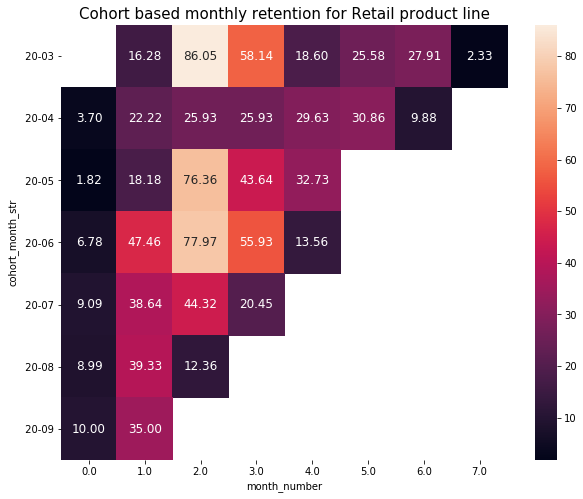

In [7]:
cohort_retail_pivot = (
  retail_retention[['cohort_month_str','month_number','percentage']]
  .pivot(columns='month_number', index='cohort_month_str')['percentage']
  )
cohort_retail_pivot

plt.figure(figsize = (10,8))
sns.heatmap(
  cohort_retail_pivot, 
 # cmap='crest', 
  annot=True,
  annot_kws={"fontsize":12},
  fmt='.2f'
  ).set_title("Cohort based monthly retention for Retail product line",fontsize = 15)
plt.yticks( rotation='360')
plt.show()

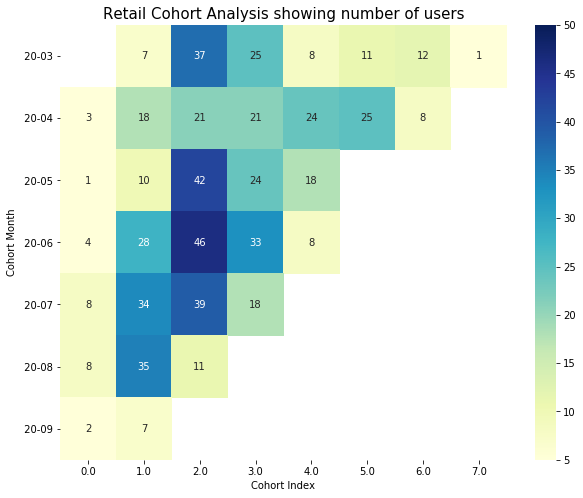

In [8]:
cohort_retail_pivot = (
  retail_retention[['cohort_month_str','month_number','num_users']]
  .pivot(columns='month_number', index='cohort_month_str')['num_users']
  )
cohort_retail_pivot
#average_standard_cost.index = average_standard_cost.index.strftime('%Y-%m')
# Initialize the figure
plt.figure(figsize=(10, 8))
# Adding a title
plt.title("Retail Cohort Analysis showing number of users",fontsize = 15)
# Creating the heatmap
sns.heatmap(cohort_retail_pivot, annot = True,vmin = 5, vmax =50,cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()



### Cohort based monthly retention for Restaurant product line

In [9]:
query="""
            with cohort_restaurant as (
                        select user_id, first_purchase_date, date_trunc('month',first_purchase_date)::date as cohort_month
                        --(extract(year from first_purchase_date::date) ||'-' ||extract(month from first_purchase_date::date) as cohort_month
                        from first_purchases
                        where product_line ilike 'restau%%'
                        order by 2
             ), purchases_restaurant as (
                        select p.user_id, first_purchase_date, purchase_date,
                        (DATE_PART('year', p.purchase_date) - DATE_PART('year', cr.first_purchase_date)) * 12 +
                                    (DATE_PART('month', p.purchase_date) - DATE_PART('month', cr.first_purchase_date)) as month_number
                        from purchases p right join cohort_restaurant cr on p.user_id = cr.user_id
                        where product_line ilike 'restau%%'
                        group by 1,2,3,4
             ), cohort_size as (
                        select cohort_month, count(user_id) as num_users
                          from cohort_restaurant
                          group by 1
                        order by 1
             ),retention as (
                          select
                        C.cohort_month,
                        A.month_number,
                        count(1) as num_users
                      from purchases_restaurant A
                      left join cohort_restaurant C ON A.user_id = C.user_id
                      group by 1, 2
              )
             select
              B.cohort_month,
              S.num_users as total_users,
              B.num_users,
              B.month_number,
              (B.num_users::float * 100 / S.num_users::float)::numeric(10,2) as percentage
              from retention B
               left join cohort_size S ON B.cohort_month = S.cohort_month
               where B.cohort_month IS NOT NULL
               order by 1, 4
                """

In [10]:
restaurant_retention = pd.io.sql.read_sql(query , con = engine)
restaurant_retention['cohort_month'] = pd.to_datetime(restaurant_retention['cohort_month'])
restaurant_retention['cohort_month_str'] = restaurant_retention.cohort_month.dt.strftime(' %y-%m')
restaurant_retention.head(10)

,cohort_month,total_users,num_users,month_number,percentage,cohort_month_str
0,2020-03-01,8157,1588,1.0,19.47,20-03
1,2020-03-01,8157,6748,2.0,82.73,20-03
2,2020-03-01,8157,7678,3.0,94.13,20-03
3,2020-03-01,8157,6484,4.0,79.49,20-03
4,2020-03-01,8157,6217,5.0,76.22,20-03
5,2020-03-01,8157,5930,6.0,72.70,20-03
6,2020-03-01,8157,2877,7.0,35.27,20-03
7,2020-04-01,13851,1687,0.0,12.18,20-04
8,2020-04-01,13851,8208,1.0,59.26,20-04
9,2020-04-01,13851,12350,2.0,89.16,20-04


### Creating visualizations showing the monthly customer retention product line Restaurant

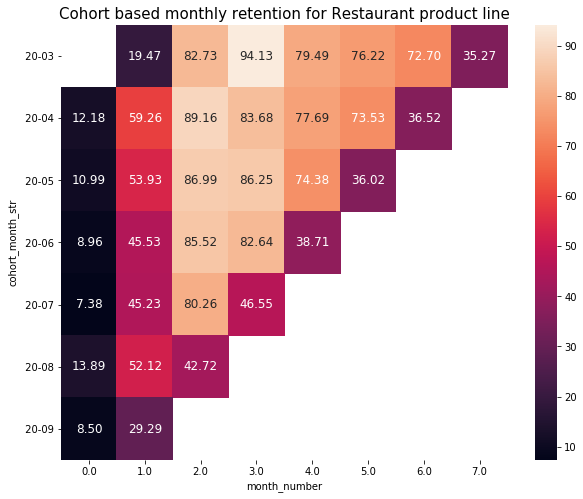

In [11]:
cohort_restaurant_pivot = (
  restaurant_retention[['cohort_month_str','month_number','percentage']]
  .pivot(columns='month_number', index='cohort_month_str')['percentage']
  )
cohort_restaurant_pivot

plt.figure(figsize = (10,8))
sns.heatmap(
  cohort_restaurant_pivot, 
 # cmap='crest', 
  annot=True,
  annot_kws={"fontsize":12},
  fmt='.2f'
  ).set_title("Cohort based monthly retention for Restaurant product line",fontsize = 15)
plt.yticks( rotation='360')


plt.show()



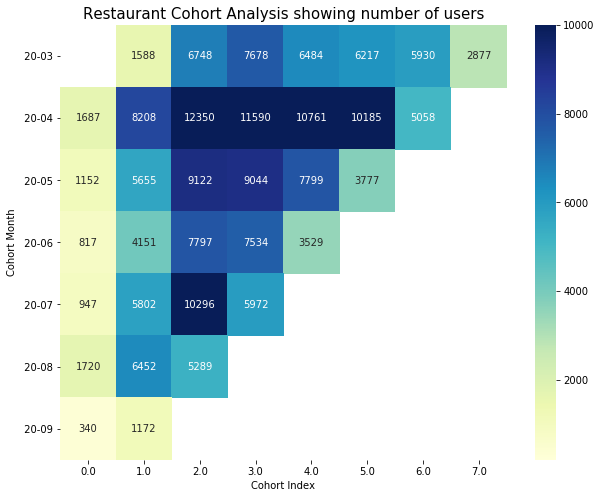

In [12]:
cohort_restaurant_pivot = (
  restaurant_retention[['cohort_month_str','month_number','num_users']]
  .pivot(columns='month_number', index='cohort_month_str')['num_users']
  )
cohort_restaurant_pivot
#average_standard_cost.index = average_standard_cost.index.strftime('%Y-%m')
# Initialize the figure
plt.figure(figsize=(10, 8))
# Adding a title
plt.title("Restaurant Cohort Analysis showing number of users",fontsize = 15)
# Creating the heatmap
sns.heatmap(cohort_restaurant_pivot, annot = True,vmin = 200, vmax =10000,cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()



Explanation and Analysis is done in the presentation pdf which is provided in the ZIP file